# prep

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import scipy.io as sio
from tqdm import tqdm
from IPython.display import clear_output

import os
import pickle
from tqdm import tqdm

%load_ext autoreload
%autoreload 2

In [3]:
local_flag = False
if local_flag:
    repo_dir = r'D:\repo\inter_data\inter'.replace("\\", "/") # under env dimred
else:
    repo_dir = r'C:\Users\ll357\Documents\inter'.replace("\\", "/")
os.chdir(repo_dir)
from src import adp

In [4]:
dir_inter = r'Z:\All_Staff\home\lan\Data\2P_images\mat_inter/'.replace('\\', '/')
dir_file = dir_inter + 'adp_dataset_master.xlsx'
data_info = pd.read_excel(dir_file)
data_info.head()

meta = data_info[(data_info.paradigm == 'grat_SF6_allen_nat8')]
meta = meta.reset_index(drop=True)
nset = meta.shape[0]
meta

,mouse,date,area,depth,num,cellpose_seg,manual_seg,paradigm,gcamp,AWS,note
0,1380,230330,V1,200.0,2,1.0,NaN,grat_SF6_allen_nat8,6s,NaN,NaN
1,1380,230330,V1,200.0,3,1.0,NaN,grat_SF6_allen_nat8,6s,NaN,NaN
2,1380,230330,V1,200.0,4,1.0,NaN,grat_SF6_allen_nat8,6s,NaN,NaN
3,1381,230404,V1,200.0,2,1.0,NaN,grat_SF6_allen_nat8,6s,NaN,NaN
4,1381,230404,V1,200.0,3,1.0,NaN,grat_SF6_allen_nat8,6s,NaN,NaN
5,1381,230404,V1,200.0,4,1.0,NaN,grat_SF6_allen_nat8,6s,NaN,NaN
6,1386,230406,V1,200.0,2,1.0,NaN,grat_SF6_allen_nat8,6s,NaN,unsure if this is V1 due to sparse cells and i...
7,1386,230406,V1,200.0,3,1.0,NaN,grat_SF6_allen_nat8,6s,NaN,NaN
8,1386,230406,V1,200.0,4,1.0,NaN,grat_SF6_allen_nat8,6s,NaN,NaN
9,1374,230411,V1,200.0,2,1.0,NaN,grat_SF6_allen_nat8,6s,NaN,NaN


# batch write df_tidy, multisess

In [30]:
for iset in tqdm(range(nset)):
    print(f'iset={iset}, nset={nset}')

    ## load data
    mouse = meta.loc[iset, 'mouse'].astype(str)
    imouse = 'i' + mouse
    date = meta.loc[iset, 'date'].astype(str)
    area = meta.loc[iset, 'area']
    print(mouse, date, area, 'multisess')
    dir_identifier = f'{area}_{imouse}_{date}'
    print(dir_identifier)

    dir_data = r'\\duhs-user-nc1.dhe.duke.edu\dusom_glickfeldlab\All_Staff\home\lan\Data\2P_images\mat_inter/'.replace('\\', '/')
    mat_inter = r'\\duhs-user-nc1.dhe.duke.edu\dusom_glickfeldlab\All_Staff\home\lan\Data\2P_images\mat_inter/'.replace('\\', '/')
    for dirname in os.listdir(mat_inter):
        if dir_identifier in dirname:
            dir_data = mat_inter + dirname
            break

    stim_id, resp_ad, resp_tg = adp.load_resp_trial(os.path.join(dir_data), vis_filter=False) # already sliced by resp time window from matlab
    assert len(np.unique(stim_id)) == 14 # for mix14
    
    ## construct dfof
    R1_dfof = resp_ad.flatten() # cell x trial, row major flatten
    R2_dfof = resp_tg.flatten()
    dfof = np.hstack((R1_dfof, R2_dfof)) # sort by cell_id, then trial_id, finally resp_id

    ## construct cell, trial, resp id
    ncell = resp_ad.shape[0]
    ntrial = resp_ad.shape[1]
    
    cell_id = np.repeat(np.arange(ncell), ntrial) # repeat cell id arr for ntrial times == sort by cell_id, then trial_id
    cell_id = np.hstack((cell_id, cell_id)) # stack two copies for R1 and R2. finally sort by resp_id

    trial_id = np.tile(np.arange(ntrial), ncell) # for each cell, go over all trials
    trial_id = np.hstack((trial_id, trial_id))

    len_df = ncell * ntrial * 2 # 2 for (R1, R2)
    resp_id = ['R1'] * int(len_df/2) + ['R2'] * int(len_df/2) # first half is flattened resp_ad, second half is flattened resp_tg
    
    stim_id = stim_id[0] # unwrap list of list
    stim_id = stim_id[:ntrial] # if stim info longer than ntrial, slice off the last one
    stim_id_col = np.tile(stim_id, ncell) # make stim info col: same as trial_id - tile then hsatck
    stim_id_col = np.hstack((stim_id_col, stim_id_col))

    df_tidy = pd.DataFrame({'dfof': dfof, 'cell_id': cell_id, 'trial_id': trial_id, 
                            'resp_id': resp_id, 'stim_id': stim_id_col,})
    df_tidy['area'] = area

    ## vis cell filter, well_fit filter, & img driven cell-stim filter
    df_tidy['filter_cell_vis'] = np.nan
    df_tidy['filter_cell_stim'] = np.nan

    with open(os.path.join(dir_data, 'vis_driven.pickle'), 'rb') as f:
        filter_file = pickle.load(f)
    filter_cell_stim = filter_file['img_driven']
    filter_cell_vis = filter_file['vis_driven']

    for icell in np.arange(filter_cell_stim.shape[0]): # filter_cell_stim is ncell x nstim
        df_tidy.loc[df_tidy['cell_id']==icell, 'filter_cell_vis'] = filter_cell_vis[icell][0] # filter_cell_vis is a list of list
        for istim in np.arange(filter_cell_stim.shape[1]):
            df_tidy.loc[(df_tidy['stim_id']==istim) & (df_tidy['cell_id']==icell), 'filter_cell_stim'] = filter_cell_stim[icell, istim]
    # df_tidy.filter_cell_vis.value_counts(), df_tidy.filter_cell_stim.value_counts()
    # break
    
    ## save df_tidy as csv
    df_tidy.to_csv(os.path.join(dir_data, 'df_tidy.csv'), index=False)

clear_output()

# batch load df_tidy

In [5]:
df_tidy = pd.DataFrame()

for idate in tqdm(meta.date.unique()):

    mouse = meta.loc[meta.date == idate, 'mouse'].head(1).values[0].astype(str) # take meta info from first session. very roundabout way to do this, bc index changes after slicing
    imouse = 'i' + mouse
    date = idate.astype(str)
    area = meta.loc[meta.date == idate, 'area'].head(1).values[0]

    print(imouse, date, area, 'multisess')
    dir_identifier = f'{area}_{imouse}_{date}'

    dir_data = r'\\duhs-user-nc1.dhe.duke.edu\dusom_glickfeldlab\All_Staff\home\lan\Data\2P_images\mat_inter/'.replace('\\', '/')
    csv_filename = 'df_tidy.csv'
    try:
        df_tidy_now = pd.read_csv(os.path.join(dir_data, dir_identifier, csv_filename))
    except:
        dir_identifier = dir_identifier + '_cellpose'
        df_tidy_now = pd.read_csv(os.path.join(dir_data, dir_identifier, csv_filename))

    df_tidy_now['mouse'] = mouse
    df_tidy_now['date'] = date
    df_tidy_now['cell_id'] = (df_tidy_now.date.astype(str) + '_' 
                            + df_tidy_now.cell_id.astype(str)) # cell_id adjusted to be unique across mice, dates
    df_tidy = pd.concat([df_tidy, df_tidy_now], axis=0).reset_index(drop=True)
    # break
    
clear_output()

In [7]:
print(df_tidy.mouse.unique(), 
      df_tidy.date.unique(), 
      df_tidy.area.unique(), )
print(sorted(df_tidy.stim_id.unique()), # NOTE: 0-based indexing. grat 6 (img 0-5), then nat 8 (img 6-13)
      df_tidy.resp_id.unique())
df_tidy.sample(5, random_state=0)

['1380' '1381' '1386' '1374' '1387' '1375'] ['230330' '230404' '230406' '230411' '230418' '230425'] ['V1']
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13] ['R1' 'R2']


,dfof,cell_id,trial_id,resp_id,stim_id,area,filter_cell_vis,filter_cell_stim,mouse,date
1001396,0.055331,230406_22,554,R1,3,V1,True,False,1386,230406
1860208,-0.060029,230418_5,1282,R2,5,V1,True,False,1387,230418
633495,0.108687,230404_80,675,R1,12,V1,True,False,1381,230404
2003814,0.040365,230418_96,198,R2,12,V1,True,False,1387,230418
594580,-0.020834,230404_55,1510,R1,8,V1,True,True,1381,230404


# filter cell

## filter cell by cutoff R1
exlude cells if even their max-resp across stims is too small  
cutoff is set as lower 5 percentile

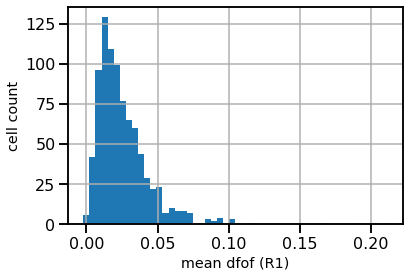

In [9]:
df_tidy[df_tidy.resp_id == 'R1'].groupby('cell_id').dfof.mean().hist(bins=50);
plt.xlabel('mean dfof (R1)');
plt.ylabel('cell count');

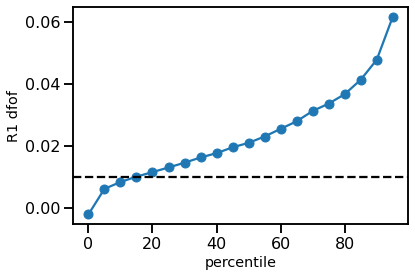

In [10]:
R1_dist = df_tidy[df_tidy.resp_id == 'R1'].groupby('cell_id').dfof.mean().values

percentile_arr = np.arange(0, 100, 5)
R1_perc = np.percentile(R1_dist, percentile_arr)

plt.plot(percentile_arr, R1_perc, 'o-');
plt.axhline(0.01, color='k', linestyle='--');
plt.xlabel('percentile');
plt.ylabel('R1 dfof');

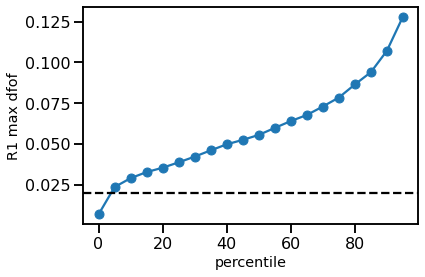

In [11]:
R1_cell_stim = df_tidy[df_tidy.resp_id == 'R1'].groupby(['cell_id', 'stim_id']).dfof.mean().to_frame().reset_index()
R1_cutoff = 0.02

# R1_cell_stim.groupby('cell_id').dfof.max().hist(bins=50); # should exclude cell if even max R1 across stims is small
# plt.axvline(R1_cutoff, color='k', linestyle='--');
# (R1_cell_stim_max < R1_cutoff).sum(), len(R1_cell_stim_max)

R1_cell_stim_max = R1_cell_stim.groupby('cell_id').dfof.max().values
R1_max_perc = np.percentile(R1_cell_stim_max, percentile_arr)
plt.plot(percentile_arr, R1_max_perc, 'o-');
plt.axhline(R1_cutoff, color='k', linestyle='--');
plt.xlabel('percentile');
plt.ylabel('R1 max dfof');

In [12]:
R1_cutoff = np.percentile(R1_max_perc, 5) # exclude cells with max R1 dfof across stims < 5th percentile

cell_list = R1_cell_stim.groupby('cell_id').dfof.max().reset_index()['cell_id'].values
filter_cell_R1 = R1_cell_stim.groupby('cell_id').dfof.max().values >= R1_cutoff
cell_R1_pass = cell_list[filter_cell_R1] # cells who passed R1 cutoff filter
len(cell_R1_pass), len(cell_list)

(821, 860)

In [13]:
df_tidy['filter_cell_R1'] = False
df_tidy['filter_cell_R1'] = df_tidy['cell_id'].apply(lambda x: True if x in cell_R1_pass else False)
assert sorted(cell_list[~filter_cell_R1]) == sorted(df_tidy[df_tidy.filter_cell_R1 == False].cell_id.unique())
df_tidy

,dfof,cell_id,trial_id,resp_id,stim_id,area,filter_cell_vis,filter_cell_stim,mouse,date,filter_cell_R1
0,-0.022064,230330_0,0,R1,1,V1,True,True,1380,230330,True
1,0.077962,230330_0,1,R1,12,V1,True,False,1380,230330,True
2,-0.023058,230330_0,2,R1,13,V1,True,True,1380,230330,True
3,0.124579,230330_0,3,R1,8,V1,True,False,1380,230330,True
4,-0.029692,230330_0,4,R1,0,V1,True,False,1380,230330,True
...,...,...,...,...,...,...,...,...,...,...,...
2731831,-0.074684,230425_194,1585,R2,12,V1,True,False,1375,230425,True
2731832,0.041901,230425_194,1586,R2,3,V1,True,True,1375,230425,True
2731833,0.007992,230425_194,1587,R2,10,V1,True,False,1375,230425,True
2731834,0.053189,230425_194,1588,R2,6,V1,True,False,1375,230425,True


# fast reload df_tidy

In [45]:
dir_data = r'\\duhs-user-nc1.dhe.duke.edu\dusom_glickfeldlab\All_Staff\home\lan\Data\2P_images\mat_inter\df tidy for plots/'.replace('\\', '/')
# df_tidy.to_csv(os.path.join(dir_data, 'df_tidy_mix14.csv'), index=False)

# ## reload df_tidy
df_tidy = pd.read_csv(os.path.join(dir_data, 'df_tidy_mix14.csv'))
df_tidy

,dfof,cell_id,trial_id,resp_id,stim_id,area,filter_cell_vis,filter_cell_stim,mouse,date,filter_cell_R1
0,-0.022064,230330_0,0,R1,1,V1,True,True,1380,230330,True
1,0.077962,230330_0,1,R1,12,V1,True,False,1380,230330,True
2,-0.023058,230330_0,2,R1,13,V1,True,True,1380,230330,True
3,0.124579,230330_0,3,R1,8,V1,True,False,1380,230330,True
4,-0.029692,230330_0,4,R1,0,V1,True,False,1380,230330,True
...,...,...,...,...,...,...,...,...,...,...,...
2731831,-0.074684,230425_194,1585,R2,12,V1,True,False,1375,230425,True
2731832,0.041901,230425_194,1586,R2,3,V1,True,True,1375,230425,True
2731833,0.007992,230425_194,1587,R2,10,V1,True,False,1375,230425,True
2731834,0.053189,230425_194,1588,R2,6,V1,True,False,1375,230425,True


## filter cell-stim by pref grat SF
to prepare for adp-SF plot

In [15]:
df_pref = df_tidy[df_tidy['filter_cell_vis'] # vis driven filter
                # & df_tidy['filter_cell_stim'] # img driven filter
                & df_tidy['filter_cell_R1'] # R1 cutoff filter
                & (df_tidy['stim_id'] < 6) # gratings only, stim id 0-5. NOTE: must have parentheses () around it!
                ]
df_pref['filter_pref'] = False

# for each cell, find the stim with the largest resp
for icell in tqdm(df_pref.cell_id.unique()):
    df_cell = df_pref[(df_pref['cell_id']==icell) & (df_pref['resp_id']=='R1')] # only use R1 to calc pref SF
    if len(df_cell) == 0:
        continue
    df_cell = (df_cell.groupby(['stim_id'])['dfof'].mean().reset_index() # mean dfof of each stim
                      .sort_values(by='dfof', ascending=False))  # sort by dfof, largest first
                      
    pref_stim = df_cell.iloc[0]['stim_id'].astype(int) # stim id of the largest resp
    df_pref.loc[(df_pref['cell_id']==icell) & (df_pref['stim_id']==pref_stim), 'filter_pref'] = True
df_pref

df_pref = df_pref[df_pref['filter_pref']] # only retain preferred stim x cell combo

C:\Users\ll357\AppData\Local\Temp\6\ipykernel_46396\464894796.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pref['filter_pref'] = False
100%|██████████| 818/818 [02:15<00:00,  6.03it/s]


In [19]:
# dir_data = r'\\duhs-user-nc1.dhe.duke.edu\dusom_glickfeldlab\All_Staff\home\lan\Data\2P_images\mat_inter\df tidy for plots/'.replace('\\', '/')
# df_pref.to_csv(os.path.join(dir_data, 'df_tidy_grat6_pref_in_mix14.csv'), index=False)

# # ## reload df_tidy
# # df_pref = pd.read_csv(os.path.join(dir_data, 'df_tidy_grat6_pref_in_mix14.csv'))

# adaptation vs preferred SF

In [20]:
# output should be of shape: nboot x nstim x ncell
# for each bootstrap, for each stim x cell, randomly select nrep trials

nboot = 1000
nrep_selected = 30 # dictated by grat1 adp stability test
seed_arr = np.random.randint(0, 100, size=nboot) # get random seed for each bootstrap

adp_boot = []
for iboot in tqdm(np.arange(nboot)):
    R1_agg = (df_pref[(df_pref['resp_id']=='R1')]
                    .groupby(['stim_id', 'cell_id'])['dfof']
                    .apply(lambda x: x.sample(n=nrep_selected, replace=True, 
                                              random_state=seed_arr[iboot]) # select same trial reps for R1 and R2
                    .mean())
                    .reset_index()['dfof'].values) # for each stim x cell, randomly select nrep trials resp, take sum
    R2_agg = (df_pref[(df_pref['resp_id']=='R2')]
                    .groupby(['stim_id', 'cell_id'])['dfof']
                    .apply(lambda x: x.sample(n=nrep_selected, replace=True, 
                                              random_state=seed_arr[iboot])
                    .mean())
                    .reset_index()['dfof'].values)
    
    # adp_agg = (R2_agg - R1_agg) / (R2_agg + R1_agg + 1e-7) # IOU version
    adp_agg = (R2_agg - R1_agg) / (R1_agg + 1e-7) # diff over R1 version
    
    adp_agg[np.abs(adp_agg) > 5] = np.nan # remove outliers
    # adp_agg[np.abs(R2_agg + R1_agg) < 0.1] = np.nan
    # adp_agg[np.abs(R1_agg) < 0.01] = np.nan
    
    adp_boot.append(adp_agg)

print('adp hard thresholding')

adp_boot = np.array(adp_boot)

100%|██████████| 1000/1000 [10:12<00:00,  1.63it/s]

adp hard thresholding


In [23]:
# adp_boot shape = nboot x (nstim x ncell, preferred), but essentially nboot x ncell, bc each cell only has 1 preferred stim

df_adp_pref = (df_pref[(df_pref['resp_id']=='R1') & (df_pref['stim_id'] < 6)] # TODO: fix code above to do this already
                .groupby(['stim_id', 'cell_id'])['dfof']
                .apply(lambda x: x.sample(n=nrep_selected, replace=True).sum()) # dfof col was not used
                .reset_index())

# agg_method = np.nanmedian
agg_method = np.nanmean

adp_boot_agg = agg_method(adp_boot, axis=0) # agg over all bootstraps
df_adp_pref['adp_pref'] = adp_boot_agg

df_adp_pref = df_adp_pref.dropna(subset=['adp_pref']) # remove nan, which is adp outliers
df_adp_pref.tail(), df_adp_pref.shape, df_adp_pref.stim_id.max()

(     stim_id     cell_id      dfof  adp_pref
 813        5  230425_147  1.594514  0.096761
 814        5   230425_28  0.010284  0.307226
 815        5   230425_47  2.689243 -0.042482
 816        5   230425_58  0.175154 -0.438129
 817        5    230425_9  0.887202  0.649820,
 (818, 4),
 5)

## fast reload df_adp_pref

In [168]:
dir_data = r'\\duhs-user-nc1.dhe.duke.edu\dusom_glickfeldlab\All_Staff\home\lan\Data\2P_images\mat_inter\df tidy for plots/'.replace('\\', '/')
# df_adp_pref.to_csv(os.path.join(dir_data, 'df_tidy_grat6_adp_pref_in_mix14.csv'), index=False)

# ## reload df_tidy
df_adp_pref = pd.read_csv(os.path.join(dir_data, 'df_tidy_grat6_adp_pref_in_mix14.csv'))

## boxplot across cells
for each SF, take cells that prefer this grating SF. boxplot errorbar is across cells

In [53]:
# df_adp_pref.loc[df_adp_pref['stim_id'] == 0, 'stim_id'] = 1 # merge stim 0 and 1
df_adp_pref

,stim_id,cell_id,dfof,adp_pref
0,0,230330_136,0.550920,-1.689821
1,0,230330_140,0.514721,-0.771892
2,0,230330_153,1.574804,-0.648641
3,0,230330_2,2.549709,-0.376793
4,0,230330_58,3.330670,0.091331
...,...,...,...,...
813,5,230425_147,1.453250,0.087655
814,5,230425_28,0.590811,0.281825
815,5,230425_47,0.924344,-0.037784
816,5,230425_58,0.040613,-0.553950


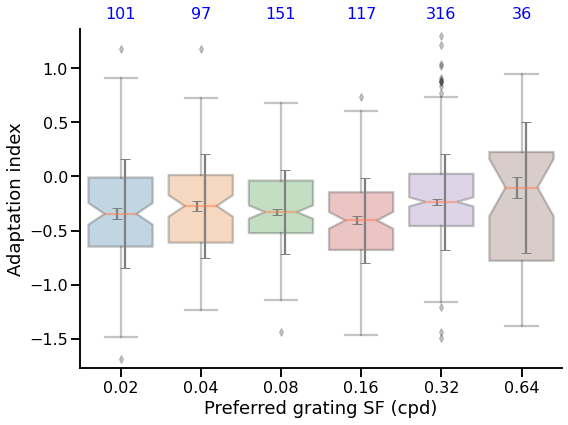

In [54]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(x='stim_id', y='adp_pref', data=df_adp_pref, ax=ax, 
            notch=True, 
            boxprops=dict(alpha=.3), 
            whiskerprops=dict(alpha=.3),
            capprops=dict(alpha=.3),
            flierprops=dict(alpha=.3),
            medianprops={"color": "coral", "alpha": .5},
            meanprops={"color": "orange"},)
# sns.swarmplot(x='stim_id', y='adp_pref', data=df_adp_pref, ax=ax, alpha=0.5) # set figsize to (18, 6) for swarmplot

adp_pref_agg = df_adp_pref.groupby('stim_id')['adp_pref'].median().values # or use mean()
adp_pref_std = df_adp_pref.groupby('stim_id')['adp_pref'].std().values
adp_pref_sem = df_adp_pref.groupby('stim_id')['adp_pref'].sem().values
ax.errorbar(np.arange(adp_pref_agg.shape[0])+0.05, adp_pref_agg,
            yerr=adp_pref_std, fmt='none', color='gray', capsize=5)
ax.errorbar(np.arange(adp_pref_agg.shape[0])-0.05, adp_pref_agg,
            yerr=adp_pref_sem, fmt='none', color='gray', capsize=5)

ncell_SF = df_adp_pref.groupby('stim_id')['cell_id'].nunique().values # ncell for each stim_id
for i, ncell_iSF in enumerate(ncell_SF):
    ncell_iSF = int(ncell_iSF)
    ax.text(i, 1.5, ncell_iSF, ha='center', va='center', fontsize=16, color='blue')

SF_ref = np.logspace(1, 6, num=6, base=2)/100 # 0.02-0.64 cpd. this should be updated to match # batch rewrite df tidy
# SF_ref = SF_ref[1:] # if merged stim 0 and 1
cpd_array = np.round(SF_ref, 2)
ax.set_xticklabels(cpd_array)
ax.set_xlabel('Preferred grating SF (cpd)', fontsize=18)
ax.set_ylabel('Adaptation index', fontsize=18)
ax.set_ylim([np.nanmin(df_adp_pref['adp_pref'].values * 1.05), np.nanmax(df_adp_pref['adp_pref'].values * 1.05)])

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
fig.tight_layout()
# dir_fig = r'C:\Users\ll357\Documents\inter\results\joint lab meeting 2023-03'.replace('\\', '/')
# fig.savefig(os.path.join(dir_fig, 'adp_pref_grat_SF6_diff_over_R1.pdf'), bbox_inches='tight')

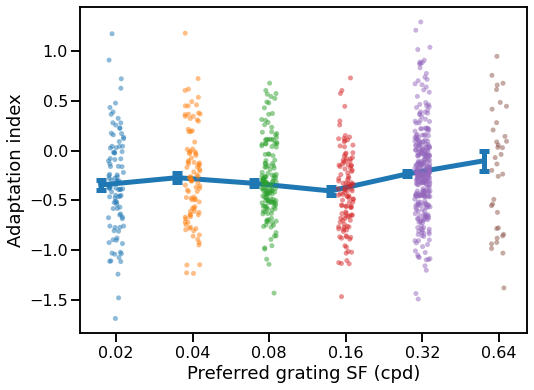

In [55]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.stripplot(x='stim_id', y='adp_pref', data=df_adp_pref, ax=ax, alpha=0.5); # set figsize to (18, 6) for swarmplot
ax.errorbar(np.arange(adp_pref_agg.shape[0])-0.2, 
            adp_pref_agg,
            yerr=adp_pref_sem, 
            linewidth=5, capsize=5, capthick=5);
ax.set_xticklabels(cpd_array);
ax.set_xticklabels(cpd_array)
ax.set_xlabel('Preferred grating SF (cpd)', fontsize=18)
ax.set_ylabel('Adaptation index', fontsize=18);

## stats

### one way anova

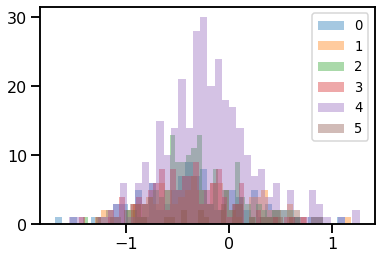

In [27]:
# test assumption of normality: looks maybe normal, need Shapiro-Wilk test

df_adp_pref_dropna = df_adp_pref.dropna(subset=['adp_pref'])
gb = df_adp_pref_dropna.groupby('stim_id')
adp_SF = []
for stim_id, group in gb:
    # print(stim_id)
    # print(group)
    # print(group['adp_pref'].values[:5])
    adp_iSF = group['adp_pref'].values
    adp_SF.append(adp_iSF)
    plt.hist(adp_iSF, bins=40, alpha=0.4, label=stim_id)
plt.legend();

In [28]:
# test assumption of equal variance: looks not equal, need Levene test, bartlett test, or fligner-killeen test
# "ANOVA is robust to heterogeneity of variance so long as the largest variance is not more than 4 times the smallest variance. general effect of heterogeneity of variance is to make the ANOVA less efficient. That is, you would have lower power" - https://stats.stackexchange.com/questions/56971/alternative-to-one-way-anova-unequal-variance
adp_SF_var = [np.var(adp_iSF) for adp_iSF in adp_SF]
adp_SF_var

# test assumption of independence: no idea

[0.2565924764785657,
 0.22165874201110278,
 0.14660475652107274,
 0.1554904006296723,
 0.19633739452017002,
 0.3578646813361963]

In [32]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

df_adp_pref_dropna = df_adp_pref.dropna()

# perform one-way ANOVA
import scipy.stats as stats
stats.f_oneway(
                df_adp_pref_dropna[df_adp_pref_dropna['stim_id']==0]['adp_pref'].values, # if merged stim 0 and 1
                df_adp_pref_dropna[df_adp_pref_dropna['stim_id']==1]['adp_pref'].values,
                df_adp_pref_dropna[df_adp_pref_dropna['stim_id']==2]['adp_pref'].values,
                df_adp_pref_dropna[df_adp_pref_dropna['stim_id']==3]['adp_pref'].values,
                df_adp_pref_dropna[df_adp_pref_dropna['stim_id']==4]['adp_pref'].values,
                df_adp_pref_dropna[df_adp_pref_dropna['stim_id']==5]['adp_pref'].values,
                )

F_onewayResult(statistic=4.157539362649587, pvalue=0.000979028581628212)

### non parametric test: kruskal-wallis
dont have to satisfy anova assumptions

In [56]:
stats.kruskal(
            df_adp_pref_dropna[df_adp_pref_dropna['stim_id']==0]['adp_pref'].values,
            df_adp_pref_dropna[df_adp_pref_dropna['stim_id']==1]['adp_pref'].values,
            df_adp_pref_dropna[df_adp_pref_dropna['stim_id']==2]['adp_pref'].values,
            df_adp_pref_dropna[df_adp_pref_dropna['stim_id']==3]['adp_pref'].values,
            df_adp_pref_dropna[df_adp_pref_dropna['stim_id']==4]['adp_pref'].values,
            df_adp_pref_dropna[df_adp_pref_dropna['stim_id']==5]['adp_pref'].values,
            )

KruskalResult(statistic=20.920875349254857, pvalue=0.0008384205395621565)

# linear decoder (single date)

## subpop divide

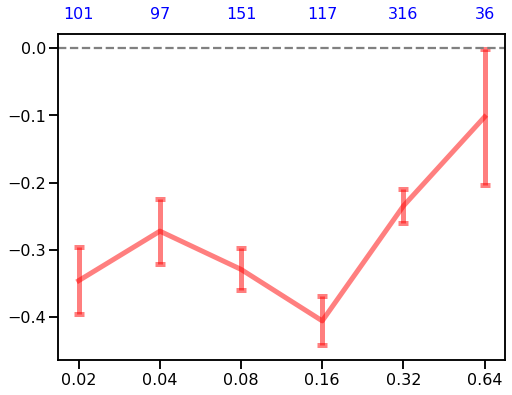

In [66]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.errorbar(np.arange(adp_pref_agg.shape[0]), 
            adp_pref_agg,
            yerr=adp_pref_sem, 
            color='red', linewidth=5, capsize=5, capthick=5, alpha=0.5);
ax.axhline(0, color='gray', linestyle='--')

ncell_SF = df_adp_pref.groupby('stim_id')['cell_id'].nunique().values # ncell for each stim_id
for i, ncell_iSF in enumerate(ncell_SF):
    ncell_iSF = int(ncell_iSF)
    ax.text(i, 0.05, ncell_iSF, ha='center', va='center', fontsize=16, color='blue')

ax.set_xticks(np.arange(adp_pref_agg.shape[0]));
ax.set_xticklabels(cpd_array);
# ax.set_ylim([np.nanmin(adp_pref_agg - adp_pref_sem) * 1.05, np.nanmax(adp_pref_agg + adp_pref_sem) * 1.1]);

In [68]:
## previous subpop division: check if low-middle pref SF cell (= less adapting cell) = better decoding. this is to test hypo: diff stim pref determines adp, which determines decoding perf

# ## expectation: "stable cells" should be cells preferring stim 4-5, aka the highest SFs
# ## "adapting cells" should be cells preferring stim 0-3, aka low-mid SFs
# ## to ensure equal ncell, take all stable cells. for adapting cells, take all cells preferring stim 3, subsample cells preferring stim 1-2
# ## lets test this grouping

# low_SF_adp = df_adp_pref[df_adp_pref.stim_id.isin([0, 1, 2, 3])].adp_pref
# high_SF_adp = df_adp_pref[df_adp_pref.stim_id.isin([4, 5])].adp_pref

# low_SF_adp.hist(bins=20, alpha=0.5);
# high_SF_adp.hist(bins=20, alpha=0.5);
# plt.xlabel('adp_pref');
# plt.ylabel('ncell');
# plt.legend(['low SF cells', 'high SF cells']);

# _, p = stats.ttest_ind(low_SF_adp, high_SF_adp) # significant difference, then try linear decoder on these two groups
# print('p = {}'.format(p))

# low_SF_cell = df_adp_pref[df_adp_pref.stim_id.isin([0, 1])].cell_id.values # subsample from here, add to mid_SF_cell
# mid_SF_cell = df_adp_pref[df_adp_pref.stim_id.isin([2, 3])].cell_id.values # this should match stable subpop
# high_SF_cell = df_adp_pref[df_adp_pref.stim_id.isin([4, 5])].cell_id.values # this should match adapting subpop

# np.random.seed(123) # randomly subsample from low_SF_cell
# subsample_ncell = len(high_SF_cell) - len(mid_SF_cell)
# low_SF_cell_subsample = np.random.choice(low_SF_cell, size=subsample_ncell, replace=False)

# mid_SF_cell = np.concatenate((mid_SF_cell, low_SF_cell_subsample))
# assert len(mid_SF_cell) == len(high_SF_cell)

In [170]:
df_adp_pref['date'] = df_adp_pref['cell_id'].str.split('_').str[0]
df_adp_pref.date.value_counts()

## let's take 230425, the date with the most cells
df_adp_pref_idate = df_adp_pref[df_adp_pref.date=='230425']
df_adp_pref_idate

,stim_id,cell_id,dfof,adp_pref,date
94,0,230425_143,1.144568,-0.518398,230425
95,0,230425_173,0.125989,-1.243827,230425
96,0,230425_181,0.246625,-0.675422,230425
97,0,230425_185,2.061106,-0.376374,230425
98,0,230425_29,1.232794,-0.759703,230425
...,...,...,...,...,...
813,5,230425_147,1.453250,0.087655,230425
814,5,230425_28,0.590811,0.281825,230425
815,5,230425_47,0.924344,-0.037784,230425
816,5,230425_58,0.040613,-0.553950,230425


0.2893850347153741


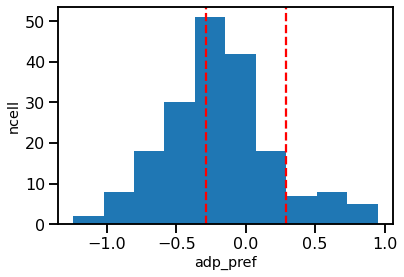

In [286]:
## current subpop division: divide by adp_pref median. not cell preference. this is to test hypo: adp to preferred stim determines decoding perf

df_adp_pref = df_adp_pref_idate.copy() # from here on, use only one date
assert df_adp_pref.groupby('cell_id').adp_pref.median().__len__() == df_adp_pref.groupby(['cell_id', 'stim_id']).adp_pref.median().__len__() # df_adp_pref contains cell-stim pairs, where one cell only prefers one stim

adp_pref_abs_med = df_adp_pref.adp_pref.abs().median() # median adp_pref across all cell-stim pairs
print(adp_pref_abs_med)

plt.hist(df_adp_pref.adp_pref, bins=10);
plt.axvline(-adp_pref_abs_med, color='red', linestyle='--');
plt.axvline(adp_pref_abs_med, color='red', linestyle='--');
plt.xlabel('adp_pref');
plt.ylabel('ncell');

## from here, divide into two subpop: stable and adapting, according to adp_pref_abs_med measured by grating stim
## but decode on natural img stim later

stable_cell = df_adp_pref[df_adp_pref.adp_pref.abs() <= adp_pref_abs_med].cell_id.unique()
adapting_cell = df_adp_pref[df_adp_pref.adp_pref.abs() > adp_pref_abs_med].cell_id.unique()

## random draw half of stable_cell and adapting_cell, no replacement
from random import sample

n_stable_half = len(stable_cell) // 2
n_adapting_half = len(adapting_cell) // 2
stable_cell_half = sample(list(stable_cell), n_stable_half) # random sampling without replacement
adapting_cell_half = sample(list(adapting_cell), n_adapting_half)
assert np.array([elem in stable_cell for elem in stable_cell_half]).all()

random_cell = stable_cell_half + adapting_cell_half
tmp = np.array((len(random_cell), len(stable_cell), len(adapting_cell)))
assert max(tmp) - min(tmp) < 2

## feature matrix & y label

In [257]:
## from dimred.py in decoding repo

from sklearn.preprocessing import StandardScaler


def z_score(X):
    # X: ndarray, shape (n_features, n_samples)
    ss = StandardScaler(with_mean=False, with_std=True) # trying mean=False, std=True for decoder. both True for dimred
    print('norm with std but not mean')
    Xz = ss.fit_transform(X.T).T
    return Xz


def z_score_norm(feature_matrix):
    print('use z score normalization after subpop separation & before dimred or decoder')
    feature_matrix = feature_matrix.copy()
    neural_data = feature_matrix.values.T # ntrial x ncell -> transpose to get nfeature x nsample
    neural_data_norm = z_score(neural_data).T # transpose back to match subpop_features
    feature_matrix.loc[:] = neural_data_norm
    return feature_matrix

In [287]:
pd.options.display.float_format = "{:,.3f}".format # set pandas df only show 3 decimal places

df_tidy_idate = df_tidy[df_tidy.date == 230425]

df_tidy_nat = df_tidy_idate[df_tidy_idate['filter_cell_vis'] # vis driven filter
                    # & df_tidy_idate['filter_cell_stim'] # img driven filter
                    & df_tidy_idate['filter_cell_R1'] # R1 cutoff filter
                    & (df_tidy_idate['stim_id'] >= 6) # natural img stim only
                    ]

df_tidy_stable = df_tidy_nat[df_tidy_nat['cell_id'].isin(stable_cell)] # only stable cells
df_tidy_adapting = df_tidy_nat[df_tidy_nat['cell_id'].isin(adapting_cell)]
df_tidy_rand = df_tidy_nat[df_tidy_nat['cell_id'].isin(random_cell)]

# df_tidy_stable.groupby('trial_id').aggregate({'resp_id': lambda x: list(x.unique()), 'stim_id': lambda x: list(x.unique())}).head(5) # note that each trial_id corresponds to R1 and R2 in a full trial, with same stim_id
df_tidy_stable.loc[:, 'trial_resp_id'] = df_tidy_stable['trial_id'].astype(str) + '_' + df_tidy_stable['resp_id'].astype(str) # combine trial_id and response to get unique trial_resp_id. # NOTE: R1 and R2 should be counted as two trials with different trial_resp_id to match previous code for allen ins data
df_tidy_adapting.loc[:, 'trial_resp_id'] = df_tidy_adapting['trial_id'].astype(str) + '_' + df_tidy_adapting['resp_id'].astype(str)
df_tidy_rand.loc[:, 'trial_resp_id'] = df_tidy_rand['trial_id'].astype(str) + '_' + df_tidy_rand['resp_id'].astype(str)
# df_tidy_stable.groupby('trial_resp_id').aggregate({'resp_id': lambda x: list(x.unique()), 'stim_id': lambda x: list(x.unique())}).head(50)
clear_output()

stable_feature = df_tidy_stable.pivot_table(index='trial_resp_id', columns='cell_id', values='dfof') # pivot df_stable to get feature matrix, ntrial x ncell. each value is dfof of one cell in one trial
adapting_feature = df_tidy_adapting.pivot_table(index='trial_resp_id', columns='cell_id', values='dfof')
rand_feature = df_tidy_rand.pivot_table(index='trial_resp_id', columns='cell_id', values='dfof')
stable_feature = z_score_norm(stable_feature)
adapting_feature = z_score_norm(adapting_feature)
rand_feature = z_score_norm(rand_feature)

assert (df_tidy_stable.groupby('trial_resp_id')[['stim_id', 'resp_id']].last().values == df_tidy_stable.groupby('trial_resp_id')[['stim_id', 'resp_id']].first().values).sum() == df_tidy_stable.groupby('trial_resp_id')[['stim_id', 'resp_id']].last().values.size # ensure each trial_resp_id only corresponds to one stim_id and one resp_id. this means each trial_resp_id corresponds to one flash of image, separating R1 vs R2 in the same trial_id
trial_info_stable = df_tidy_stable.groupby('trial_resp_id')[['stim_id', 'resp_id']].last()
trial_info_adapting = df_tidy_adapting.groupby('trial_resp_id')[['stim_id', 'resp_id']].last()
trial_info_rand = df_tidy_rand.groupby('trial_resp_id')[['stim_id', 'resp_id']].last()

stable_df = trial_info_stable.merge(stable_feature, how='outer', on='trial_resp_id')
adapting_df = trial_info_adapting.merge(adapting_feature, how='outer', on='trial_resp_id')
rand_df = trial_info_rand.merge(rand_feature, how='outer', on='trial_resp_id')
assert stable_df.isna().sum().sum() == 0 # count nan in stable_df, should be 0
assert (trial_info_adapting.index == stable_feature.index).all() # ensure trial_info and stable_feature have same index, aka trial_resp_id

rand_df

use z score normalization after subpop separation & before dimred or decoder
norm with std but not mean
use z score normalization after subpop separation & before dimred or decoder
norm with std but not mean
use z score normalization after subpop separation & before dimred or decoder
norm with std but not mean


,stim_id,resp_id,230425_10,230425_100,230425_101,230425_102,230425_104,230425_107,230425_111,230425_113,...,230425_85,230425_88,230425_89,230425_9,230425_90,230425_92,230425_93,230425_94,230425_97,230425_98
trial_resp_id,,,,,,,,,,,,,,,,,,,,,
0_R1,10,R1,-1.260,2.755,0.387,2.519,4.102,2.091,2.538,3.470,...,4.244,2.357,3.166,-0.586,-0.233,3.238,0.991,-0.765,1.973,0.782
0_R2,10,R2,2.232,-0.398,-0.197,-0.882,-1.027,-0.434,4.931,-0.619,...,-1.417,-0.457,-1.639,0.871,-0.404,-0.612,-0.245,0.158,-0.094,-0.969
1000_R1,9,R1,-0.182,1.434,0.070,0.120,0.726,-0.499,-0.554,0.014,...,0.607,1.503,0.060,0.211,0.488,0.420,0.320,0.109,-0.338,0.619
1000_R2,9,R2,-0.835,2.786,0.036,-0.063,0.156,-0.830,1.167,-0.090,...,-0.506,-0.468,0.557,0.358,-0.215,0.740,0.021,0.548,-0.022,0.767
1003_R1,8,R1,-0.493,0.070,0.074,0.062,0.101,0.040,0.863,-0.326,...,-0.151,1.346,0.302,0.058,-0.128,0.192,-0.145,0.236,-0.078,0.816
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
997_R2,7,R2,-0.585,0.431,0.395,0.058,0.330,0.494,1.011,5.298,...,-0.230,1.012,-0.338,0.392,-0.114,0.348,0.084,1.015,-0.591,-1.030
998_R1,13,R1,0.172,0.199,0.471,0.019,-0.134,0.034,0.732,0.371,...,-0.420,0.312,0.122,-0.216,0.572,0.956,0.723,1.013,0.456,-0.281
998_R2,13,R2,-0.227,0.331,-0.043,0.090,-0.401,0.079,0.337,1.869,...,-0.037,0.705,1.034,-0.879,2.093,0.843,0.931,0.931,0.411,-0.301


### format data for model

In [302]:
def get_model_data(features_subpop, df_subpop):
    '''balancing training data for: any subpop, before vs after adaptation vs random half trials'''
    from sklearn.model_selection import StratifiedKFold

    full_X = features_subpop
    full_y = df_subpop.stim_id
    unadapted_X = features_subpop[df_subpop.resp_id == 'R1'] # X and y are aligned - same order of rows (trials)
    unadapted_y = df_subpop[df_subpop.resp_id == 'R1'].stim_id
    adapted_X = features_subpop[df_subpop.resp_id == 'R2']
    adapted_y = df_subpop[df_subpop.resp_id == 'R2'].stim_id
    print([full_X.shape, full_y.shape, unadapted_X.shape, unadapted_y.shape, adapted_X.shape, adapted_y.shape]) # X: ntrial_resp_id x ncell_id. y: ntrial_resp_id x 1

    adapted_X_n = adapted_X.reset_index(drop=True).values
    adapted_y_n = adapted_y.reset_index(drop=True).values
    unadapted_X_n = unadapted_X.copy().reset_index(drop=True).values
    unadapted_y_n = unadapted_y.copy().reset_index(drop=True).values
    # full_X_n = full_X.copy().reset_index(drop=True)
    # full_y_n = full_y.copy().reset_index(drop=True)

    full_X = full_X.reset_index(drop=True).values
    full_y = full_y.reset_index(drop=True).values
    skf = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)
    skf.get_n_splits(full_X, full_y) # bc full_X contains both R1 and R2 trial_resp_id, should subsample half
    for train_index, test_index in skf.split(full_X, full_y):
        full_X_n, full_X_discard = full_X[train_index], full_X[test_index]
        full_y_n, full_y_discard = full_y[train_index], full_y[test_index]

    # count values in full_y_n, and full_y_discard
    print(np.unique(full_y_n, return_counts=True))
    print(np.unique(full_y_discard, return_counts=True))
    print(np.unique(unadapted_y_n, return_counts=True))
    print(np.unique(adapted_y_n, return_counts=True)) # full_y_n, unadapted_y_n, and adapted_y_n should have same counts of each y label

    return full_X_n, full_y_n, unadapted_X_n, unadapted_y_n, adapted_X_n, adapted_y_n


def grid_search_lin_decoder(X_training, y_training, nFold=5):
    import time
    from sklearn.model_selection import GridSearchCV
    from sklearn.linear_model import SGDClassifier

    param_grid = { 
                    'loss' : ('hinge', # (soft-margin) linear SVM
                            'modified_huber', # is another smooth loss that brings tolerance to outliers as well as probability estimates
                            'log', # logistic regression, a probabilistic classifier
                            'squared_hinge', # is like hinge but is quadratically penalized
                            'perceptron'), # is the linear loss used by the perceptron algorithm

                    'alpha' : [1e-4, 1e-3, 1e-2, 1e-1, 1, 10], 

                    'penalty' : ['elasticnet'],

                    'l1_ratio' : np.round(np.arange(1, -.1, -.2), 3)
                }

    total_time = time.time()
    clf_model = GridSearchCV(SGDClassifier(max_iter=1000), param_grid, cv=nFold, verbose=10)    
    clf_model.fit(X_training, y_training)
    print("Done! Total Time: ", np.round((time.time() - total_time), 3), 's' ) # 20 min -> 4.5 min -> 18 min

    return clf_model


def viz_best_lin_decoder(clf_model, neuron_group, trial_group):
    cv_results = pd.DataFrame(clf_model.cv_results_)
    nbest = 50
    best_model = cv_results[cv_results['rank_test_score'] < nbest+1]

    f, axes = plt.subplots(1,1, figsize=(12, 6))
    for i in np.arange(nFold):
        col = 'split' + str(i) + '_test_score'
        sns.scatterplot(data=best_model, y=col, x='rank_test_score', ax=axes, color='b', alpha=.5)

    fig = sns.scatterplot(data=best_model, y='mean_test_score', x='rank_test_score', ax=axes, color='k')
    # axes.set_xticks(np.arange(nbest+1))
    # axes.set_yticks(np.arange(0.75, 1.01, 0.05))
    # axes.set_ylim([0.75, 1.01])
    axes.set_title(f'Performance: {neuron_group}_{trial_group}')
    axes.set_ylabel('performance');
    # plt.savefig(os.path.join(dir_fig, f'model_full_best_{session_id}.pdf'), bbox_inches = 'tight')

    print(best_model.sort_values(by=['mean_test_score'], ascending=False).head(5).mean_test_score)
    return best_model

## rand half cell

In [299]:
features_subpop = rand_feature.copy()
df_subpop = rand_df.copy()
full_X_n, full_y_n, unadapted_X_n, unadapted_y_n, adapted_X_n, adapted_y_n = get_model_data(features_subpop, df_subpop)
half_cell_col = rand_feature.columns # np.array([int(elem) for elem in all_cells_features.columns])

[(1822, 94), (1822,), (911, 94), (911,), (911, 94), (911,)]
(array([ 6,  7,  8,  9, 10, 11, 12, 13], dtype=int64), array([114, 114, 114, 114, 114, 114, 113, 114], dtype=int64))
(array([ 6,  7,  8,  9, 10, 11, 12, 13], dtype=int64), array([114, 114, 114, 114, 114, 114, 113, 114], dtype=int64))
(array([ 6,  7,  8,  9, 10, 11, 12, 13], dtype=int64), array([114, 114, 114, 114, 114, 114, 113, 114], dtype=int64))
(array([ 6,  7,  8,  9, 10, 11, 12, 13], dtype=int64), array([114, 114, 114, 114, 114, 114, 113, 114], dtype=int64))


117   0.341
72    0.340
77    0.332
115   0.329
111   0.329
Name: mean_test_score, dtype: float64


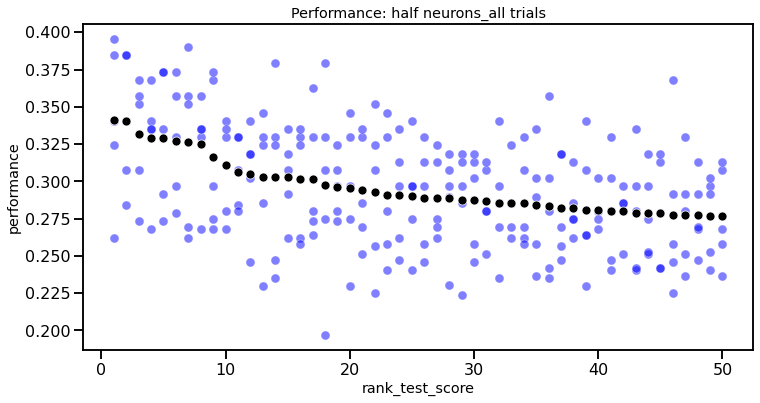

In [303]:
nFold = 5
clf_full = grid_search_lin_decoder(full_X_n, full_y_n)
clear_output()
best_full_half_cell = viz_best_lin_decoder(clf_full, 'half neurons', 'all trials')

77    0.344
117   0.335
72    0.333
115   0.333
85    0.330
Name: mean_test_score, dtype: float64


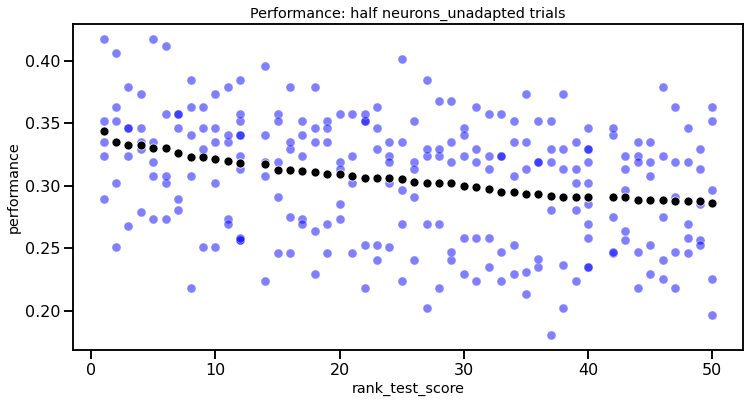

In [315]:
clf_un = grid_search_lin_decoder(unadapted_X_n, unadapted_y_n)
clear_output()
best_un_half_cell = viz_best_lin_decoder(clf_un, 'half neurons', 'unadapted trials')

In [316]:
clf_ad = grid_search_lin_decoder(adapted_X_n, adapted_y_n)
clear_output()
best_ad_half_cell = viz_best_lin_decoder(clf_ad, 'half neurons', 'adapted trials')

Fitting 5 folds for each of 180 candidates, totalling 900 fits
[CV 1/5; 1/180] START alpha=0.0001, l1_ratio=1.0, loss=hinge, penalty=elasticnet
[CV 1/5; 1/180] END alpha=0.0001, l1_ratio=1.0, loss=hinge, penalty=elasticnet;, score=0.246 total time=   0.1s
[CV 2/5; 1/180] START alpha=0.0001, l1_ratio=1.0, loss=hinge, penalty=elasticnet
[CV 2/5; 1/180] END alpha=0.0001, l1_ratio=1.0, loss=hinge, penalty=elasticnet;, score=0.286 total time=   0.1s
[CV 3/5; 1/180] START alpha=0.0001, l1_ratio=1.0, loss=hinge, penalty=elasticnet
[CV 3/5; 1/180] END alpha=0.0001, l1_ratio=1.0, loss=hinge, penalty=elasticnet;, score=0.330 total time=   0.1s
[CV 4/5; 1/180] START alpha=0.0001, l1_ratio=1.0, loss=hinge, penalty=elasticnet
[CV 4/5; 1/180] END alpha=0.0001, l1_ratio=1.0, loss=hinge, penalty=elasticnet;, score=0.319 total time=   0.1s
[CV 5/5; 1/180] START alpha=0.0001, l1_ratio=1.0, loss=hinge, penalty=elasticnet
[CV 5/5; 1/180] END alpha=0.0001, l1_ratio=1.0, loss=hinge, penalty=elasticnet;, sco

c:\Users\ll357\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 32/180] END alpha=0.001, l1_ratio=1.0, loss=modified_huber, penalty=elasticnet;, score=0.240 total time=   1.1s
[CV 2/5; 32/180] START alpha=0.001, l1_ratio=1.0, loss=modified_huber, penalty=elasticnet


c:\Users\ll357\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5; 32/180] END alpha=0.001, l1_ratio=1.0, loss=modified_huber, penalty=elasticnet;, score=0.280 total time=   1.1s
[CV 3/5; 32/180] START alpha=0.001, l1_ratio=1.0, loss=modified_huber, penalty=elasticnet


c:\Users\ll357\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 32/180] END alpha=0.001, l1_ratio=1.0, loss=modified_huber, penalty=elasticnet;, score=0.308 total time=   1.3s
[CV 4/5; 32/180] START alpha=0.001, l1_ratio=1.0, loss=modified_huber, penalty=elasticnet


c:\Users\ll357\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 4/5; 32/180] END alpha=0.001, l1_ratio=1.0, loss=modified_huber, penalty=elasticnet;, score=0.297 total time=   0.6s
[CV 5/5; 32/180] START alpha=0.001, l1_ratio=1.0, loss=modified_huber, penalty=elasticnet
[CV 5/5; 32/180] END alpha=0.001, l1_ratio=1.0, loss=modified_huber, penalty=elasticnet;, score=0.286 total time=   0.6s
[CV 1/5; 33/180] START alpha=0.001, l1_ratio=1.0, loss=log, penalty=elasticnet..
[CV 1/5; 33/180] END alpha=0.001, l1_ratio=1.0, loss=log, penalty=elasticnet;, score=0.257 total time=   0.8s
[CV 2/5; 33/180] START alpha=0.001, l1_ratio=1.0, loss=log, penalty=elasticnet..
[CV 2/5; 33/180] END alpha=0.001, l1_ratio=1.0, loss=log, penalty=elasticnet;, score=0.313 total time=   0.8s
[CV 3/5; 33/180] START alpha=0.001, l1_ratio=1.0, loss=log, penalty=elasticnet..
[CV 3/5; 33/180] END alpha=0.001, l1_ratio=1.0, loss=log, penalty=elasticnet;, score=0.352 total time=   0.7s
[CV 4/5; 33/180] START alpha=0.001, l1_ratio=1.0, loss=log, penalty=elasticnet..
[CV 4/5; 33/18

c:\Users\ll357\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 34/180] END alpha=0.001, l1_ratio=1.0, loss=squared_hinge, penalty=elasticnet;, score=0.262 total time=   0.9s
[CV 2/5; 34/180] START alpha=0.001, l1_ratio=1.0, loss=squared_hinge, penalty=elasticnet


c:\Users\ll357\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5; 34/180] END alpha=0.001, l1_ratio=1.0, loss=squared_hinge, penalty=elasticnet;, score=0.302 total time=   0.9s
[CV 3/5; 34/180] START alpha=0.001, l1_ratio=1.0, loss=squared_hinge, penalty=elasticnet


c:\Users\ll357\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 34/180] END alpha=0.001, l1_ratio=1.0, loss=squared_hinge, penalty=elasticnet;, score=0.324 total time=   0.9s
[CV 4/5; 34/180] START alpha=0.001, l1_ratio=1.0, loss=squared_hinge, penalty=elasticnet


c:\Users\ll357\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 4/5; 34/180] END alpha=0.001, l1_ratio=1.0, loss=squared_hinge, penalty=elasticnet;, score=0.264 total time=   1.0s
[CV 5/5; 34/180] START alpha=0.001, l1_ratio=1.0, loss=squared_hinge, penalty=elasticnet


c:\Users\ll357\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/5; 34/180] END alpha=0.001, l1_ratio=1.0, loss=squared_hinge, penalty=elasticnet;, score=0.280 total time=   1.2s
[CV 1/5; 35/180] START alpha=0.001, l1_ratio=1.0, loss=perceptron, penalty=elasticnet
[CV 1/5; 35/180] END alpha=0.001, l1_ratio=1.0, loss=perceptron, penalty=elasticnet;, score=0.262 total time=   0.6s
[CV 2/5; 35/180] START alpha=0.001, l1_ratio=1.0, loss=perceptron, penalty=elasticnet
[CV 2/5; 35/180] END alpha=0.001, l1_ratio=1.0, loss=perceptron, penalty=elasticnet;, score=0.291 total time=   0.5s
[CV 3/5; 35/180] START alpha=0.001, l1_ratio=1.0, loss=perceptron, penalty=elasticnet
[CV 3/5; 35/180] END alpha=0.001, l1_ratio=1.0, loss=perceptron, penalty=elasticnet;, score=0.319 total time=   0.5s
[CV 4/5; 35/180] START alpha=0.001, l1_ratio=1.0, loss=perceptron, penalty=elasticnet
[CV 4/5; 35/180] END alpha=0.001, l1_ratio=1.0, loss=perceptron, penalty=elasticnet;, score=0.286 total time=   0.4s
[CV 5/5; 35/180] START alpha=0.001, l1_ratio=1.0, loss=perceptron, p

c:\Users\ll357\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5; 39/180] END alpha=0.001, l1_ratio=0.8, loss=squared_hinge, penalty=elasticnet;, score=0.242 total time=   0.7s
[CV 3/5; 39/180] START alpha=0.001, l1_ratio=0.8, loss=squared_hinge, penalty=elasticnet


c:\Users\ll357\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 39/180] END alpha=0.001, l1_ratio=0.8, loss=squared_hinge, penalty=elasticnet;, score=0.319 total time=   0.7s
[CV 4/5; 39/180] START alpha=0.001, l1_ratio=0.8, loss=squared_hinge, penalty=elasticnet


c:\Users\ll357\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 4/5; 39/180] END alpha=0.001, l1_ratio=0.8, loss=squared_hinge, penalty=elasticnet;, score=0.269 total time=   0.5s
[CV 5/5; 39/180] START alpha=0.001, l1_ratio=0.8, loss=squared_hinge, penalty=elasticnet


c:\Users\ll357\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/5; 39/180] END alpha=0.001, l1_ratio=0.8, loss=squared_hinge, penalty=elasticnet;, score=0.247 total time=   0.7s
[CV 1/5; 40/180] START alpha=0.001, l1_ratio=0.8, loss=perceptron, penalty=elasticnet
[CV 1/5; 40/180] END alpha=0.001, l1_ratio=0.8, loss=perceptron, penalty=elasticnet;, score=0.273 total time=   0.2s
[CV 2/5; 40/180] START alpha=0.001, l1_ratio=0.8, loss=perceptron, penalty=elasticnet
[CV 2/5; 40/180] END alpha=0.001, l1_ratio=0.8, loss=perceptron, penalty=elasticnet;, score=0.269 total time=   0.2s
[CV 3/5; 40/180] START alpha=0.001, l1_ratio=0.8, loss=perceptron, penalty=elasticnet
[CV 3/5; 40/180] END alpha=0.001, l1_ratio=0.8, loss=perceptron, penalty=elasticnet;, score=0.302 total time=   0.2s
[CV 4/5; 40/180] START alpha=0.001, l1_ratio=0.8, loss=perceptron, penalty=elasticnet
[CV 4/5; 40/180] END alpha=0.001, l1_ratio=0.8, loss=perceptron, penalty=elasticnet;, score=0.291 total time=   0.2s
[CV 5/5; 40/180] START alpha=0.001, l1_ratio=0.8, loss=perceptron, p

c:\Users\ll357\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 62/180] END alpha=0.01, l1_ratio=1.0, loss=modified_huber, penalty=elasticnet;, score=0.279 total time=   2.0s
[CV 2/5; 62/180] START alpha=0.01, l1_ratio=1.0, loss=modified_huber, penalty=elasticnet


c:\Users\ll357\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5; 62/180] END alpha=0.01, l1_ratio=1.0, loss=modified_huber, penalty=elasticnet;, score=0.297 total time=   1.9s
[CV 3/5; 62/180] START alpha=0.01, l1_ratio=1.0, loss=modified_huber, penalty=elasticnet


c:\Users\ll357\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 62/180] END alpha=0.01, l1_ratio=1.0, loss=modified_huber, penalty=elasticnet;, score=0.313 total time=   2.0s
[CV 4/5; 62/180] START alpha=0.01, l1_ratio=1.0, loss=modified_huber, penalty=elasticnet


c:\Users\ll357\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 4/5; 62/180] END alpha=0.01, l1_ratio=1.0, loss=modified_huber, penalty=elasticnet;, score=0.313 total time=   1.8s
[CV 5/5; 62/180] START alpha=0.01, l1_ratio=1.0, loss=modified_huber, penalty=elasticnet


c:\Users\ll357\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/5; 62/180] END alpha=0.01, l1_ratio=1.0, loss=modified_huber, penalty=elasticnet;, score=0.319 total time=   1.9s
[CV 1/5; 63/180] START alpha=0.01, l1_ratio=1.0, loss=log, penalty=elasticnet...
[CV 1/5; 63/180] END alpha=0.01, l1_ratio=1.0, loss=log, penalty=elasticnet;, score=0.295 total time=   0.3s
[CV 2/5; 63/180] START alpha=0.01, l1_ratio=1.0, loss=log, penalty=elasticnet...
[CV 2/5; 63/180] END alpha=0.01, l1_ratio=1.0, loss=log, penalty=elasticnet;, score=0.313 total time=   0.4s
[CV 3/5; 63/180] START alpha=0.01, l1_ratio=1.0, loss=log, penalty=elasticnet...
[CV 3/5; 63/180] END alpha=0.01, l1_ratio=1.0, loss=log, penalty=elasticnet;, score=0.319 total time=   0.3s
[CV 4/5; 63/180] START alpha=0.01, l1_ratio=1.0, loss=log, penalty=elasticnet...
[CV 4/5; 63/180] END alpha=0.01, l1_ratio=1.0, loss=log, penalty=elasticnet;, score=0.385 total time=   0.3s
[CV 5/5; 63/180] START alpha=0.01, l1_ratio=1.0, loss=log, penalty=elasticnet...
[CV 5/5; 63/180] END alpha=0.01, l1_rat

c:\Users\ll357\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5; 64/180] END alpha=0.01, l1_ratio=1.0, loss=squared_hinge, penalty=elasticnet;, score=0.230 total time=   1.9s
[CV 2/5; 64/180] START alpha=0.01, l1_ratio=1.0, loss=squared_hinge, penalty=elasticnet


c:\Users\ll357\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5; 64/180] END alpha=0.01, l1_ratio=1.0, loss=squared_hinge, penalty=elasticnet;, score=0.302 total time=   1.6s
[CV 3/5; 64/180] START alpha=0.01, l1_ratio=1.0, loss=squared_hinge, penalty=elasticnet


c:\Users\ll357\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5; 64/180] END alpha=0.01, l1_ratio=1.0, loss=squared_hinge, penalty=elasticnet;, score=0.341 total time=   1.8s
[CV 4/5; 64/180] START alpha=0.01, l1_ratio=1.0, loss=squared_hinge, penalty=elasticnet


c:\Users\ll357\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 4/5; 64/180] END alpha=0.01, l1_ratio=1.0, loss=squared_hinge, penalty=elasticnet;, score=0.330 total time=   2.0s
[CV 5/5; 64/180] START alpha=0.01, l1_ratio=1.0, loss=squared_hinge, penalty=elasticnet


## adapting cell

In [ ]:
features_subpop = adapting_feature.copy()
df_subpop = adapting_df.copy()
full_X_n, full_y_n, unadapted_X_n, unadapted_y_n, adapted_X_n, adapted_y_n = get_model_data(features_subpop, df_subpop)
adapting_cell_col = adapting_feature.columns

In [ ]:
clf_full_adapting = grid_search_lin_decoder(full_X_n, full_y_n)
clear_output()
best_full_adapting = viz_best_lin_decoder(clf_full_adapting, 'adapting neurons', 'all trials')

In [ ]:
clf_un_adapting = grid_search_lin_decoder(unadapted_X_n, unadapted_y_n)
clear_output()
best_un_adapting = viz_best_lin_decoder(clf_un_adapting, 'adapting neurons', 'R1 trials')

In [ ]:
clf_ad_adapting = grid_search_lin_decoder(adapted_X_n, adapted_y_n)
clear_output()
best_ad_adapting = viz_best_lin_decoder(clf_ad_adapting, 'adapting neurons', 'R2 trials')

## stable cell

In [ ]:
features_subpop = stable_feature.copy()
df_subpop = stable_df.copy()
full_X_n, full_y_n, unadapted_X_n, unadapted_y_n, adapted_X_n, adapted_y_n = get_model_data(features_subpop, df_subpop)
stable_cell_col = stable_feature.columns

In [ ]:
clf_full_stable = grid_search_lin_decoder(full_X_n, full_y_n)
clear_output()
best_full_stable = viz_best_lin_decoder(clf_full_stable, 'stable neurons', 'all trials')

In [ ]:
clf_un_stable = grid_search_lin_decoder(unadapted_X_n, unadapted_y_n)
clear_output()
best_un_stable = viz_best_lin_decoder(clf_un_stable, 'stable neurons', 'R1 trials')

In [ ]:
clf_ad_stable = grid_search_lin_decoder(adapted_X_n, adapted_y_n)
clear_output()
best_ad_stable = viz_best_lin_decoder(clf_ad_stable, 'stable neurons', 'R2 trials')

In [ ]:
x = np.arange(3)
y_adapting = [best_un_adapting.mean_test_score.max(), best_ad_adapting.mean_test_score.max(), best_full_adapting.mean_test_score.max(), ]
y_stable = [best_un_stable.mean_test_score.max(), best_ad_stable.mean_test_score.max(), best_full_stable.mean_test_score.max(), ]
y_half_cell = [best_un_half_cell.mean_test_score.max(), best_ad_half_cell.mean_test_score.max(), best_full_half_cell.mean_test_score.max()]
y_adapting, y_stable, y_half_cell # TODO: add error bars for 5-fold CV

In [ ]:
plt.rcParams.update(plt.rcParamsDefault)

plt.figure(figsize=(6,5))
alpha = 0.5
plt.plot(x, y_stable, label='stable neurons', linewidth=3, alpha=alpha)
plt.plot(x, y_half_cell, label='random half neurons', linewidth=3, alpha=alpha)
plt.plot(x, y_adapting, label='adapting neurons', linewidth=3, alpha=alpha)
plt.hlines(y=0.125, xmin=0, xmax=2, linestyles='-.', colors='gray', label='chance level')

plt.legend(fontsize=16, frameon=False, loc=5, borderaxespad=0.)
xlabels = ['R1', 'R2', 'R1 & R2']
plt.xticks(x, xlabels, rotation=0, fontsize=16);
plt.ylim(-0, 1.0);
plt.yticks(np.arange(0.1,1.01,0.1), fontsize=14)
plt.ylabel("Performance", fontsize=18);
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.tight_layout()

# plt.savefig(dir_fig + f'/linear_decoder_perf_{session_id}_subpop_respwin_debug_R1.pdf', format='pdf')